In [45]:
%matplotlib inline
import argparse
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [46]:
# set a manual seed to prevent different result while every running

manualSeed = 999
print("Random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [47]:
data_root = "./CAN_image_dataset(RGB)/"    # dataset root
workers = 1                 # using thread numbers
batch_size = 128            # batch_size
nc = 1                      # number of channel from input images
num_epochs = 20             # number of training epochs
lr = 0.0002                 # learning rate
beta1 = 0.5                 # hyperparameter for adam optimizer
ngpu = 1                    # number of available gpu

In [48]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=True,num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

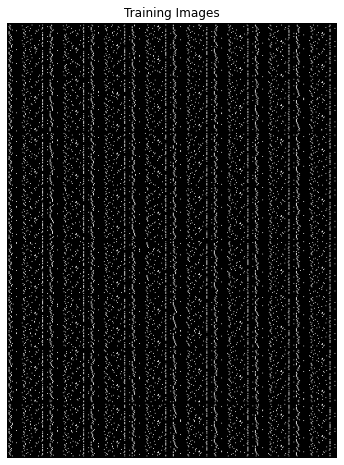

In [49]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))

In [50]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
# v1 : except nn.BatchNorm2d(channel size)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input : N x channel noise x 1 x 1
            nn.ConvTranspose2d(256,512,(3,4),stride=1,bias=False),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # fourth layer,
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # Final layer
            nn.ConvTranspose2d(64,3,4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        return self.main(input)

In [53]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(3, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Tanh()
  )
)


In [55]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu,
        self.main = nn.Sequential(
            nn.Conv2d(3,3,(4,3),stride=(2,1),padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(3,3,(4,3),stride=(2,1),padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(3,1,(16,48),stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [56]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 3, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(3, 1, kernel_size=(16, 48), stride=(1, 1), bias=False)
    (5): Sigmoid()
  )
)


In [57]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(1,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [ ]:
# train process

# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in range(num_epochs):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



Starting Training Loop...


In [ ]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

In [ ]:
# bring real datas form dataloader
real_batch = next(iter(dataloader))

# print real images on display
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Fake CAN Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()